In [6]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import pandas as pd
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import control
import random

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

## Sistemas de orden 1 y 2 con tiempo muerto

Es un método de identificación que se basa en características que presenta la curva de respuesta del sistema frente a una entrada de escalón o cualquier entrada. Estas características pueden ser: Valor final, tiempo de estabilización, sobrepaso máximo, etc.

## Sistemas de primer orden con tiempo muerto

Un sistema de primer orden es aquel que en su modelo analítico en tiempo continuo, involucra por lo menos una primera derivada de la variable de interés. Los parámetros a tener en cuenta para la identificación son: Constante de tiempo($\tau$), ganancia (K).

$$G(s)=\frac{K e^{-\theta s}}{\tau s + 1}$$

$\tau$: Hace referencia a la velocidad de respuesta del sistema, tanto más grande la constante de tiempo más lento responde el sistema.

$\theta$: Hace referencia al tiempo muerto o tiempo que el sistema se mantiene sin responder a la entrada.

La aproximación de Padé permite reescribir en términos de numerador y denominador la expresión $e^{-\theta s}$ según el orden de la aproximación de Padé.

Padé de orden 1:

$$e^{-\theta s} \approx \frac{1-\frac{\theta}{2}s}{1 + \frac{\theta}{2}s}$$

Padé de orden 2:

$$e^{-\theta s} \approx \frac{1-\frac{\theta}{2}s+\frac{\theta^2}{12}s^2}{1 + \frac{\theta}{2}s+\frac{\theta^2}{12}s^2}$$


Por ejemplo, si modelamos una adquisición de datos de un sistema de primer orden así:

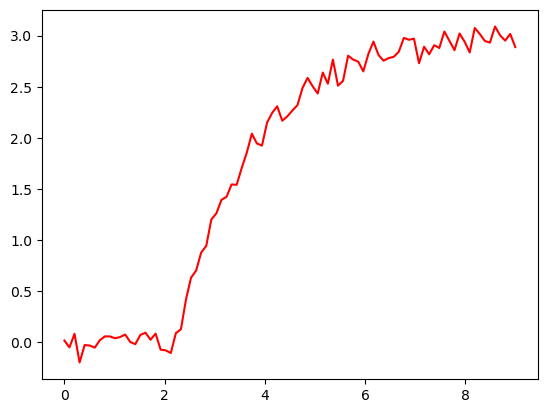

In [7]:
## Respuesta típica de un sistema de primer orden con ruido
## Simulando el experimento de medición
K = 3
tao = 1.5
tf = 6*tao
delay = 2.3
dt = 0.1

n0 = int(delay/dt)
ceros = np.zeros(n0)

### Sistema con retardo
t1 = np.linspace(0,tf-delay,int((tf-delay)/dt)+1)
g = control.tf(K,[tao,1])
_,y = control.step_response(g,t1)
y = np.append(ceros,y)
N = len(y)

## Ruido para simular la señal de salida capturada "yn"
r = 0.08
e = np.random.normal(0,r,size=N)
yn = y+e
t = np.linspace(0,tf,N)
plt.plot(t,yn,color = 'red')

## Experimento de identificación

**Paso 1:** Identificar el 63.2% del valor final para poder determinar el $\tau$ del sistema. Y el tiempo de establecimiento ($t_s = 4\tau-t_d$).

In [3]:
## Determinando tao (sin conocer al función original)
tao = 0;

## Visualmente definimos el 60% del valor final
V6 = 0.632*K;

for k in range(N):
    if(yn[k]>=V6):
        tao = t[k]
        break
## Calculando el tiempo de establecimiento
tao = tao - delay
ts = 4*tao + delay
tao, ts

**Paso 2:** Determinar una aproximación del valor final, para este caso es calcular el valor promedio de todas las "yn" para un tiempo mayor al de establecimiento.

In [4]:
## Calculando el valor final (Sin conocer sistema original)
Kf = 0
i1 = k;
i2 = 0;
for j in range(N):
    if(t[j]>ts):
        Kf = Kf+yn[j]
        i1 = i1+1
        i2 = i2+1
        
Kf = Kf/i2             
print(Kf)

2.974360374066381


**Paso 3:** Armar la función de transferencia estimada

TransferFunction(array([ 2.97436037e+00, -1.42252018e+02,  3.33982999e+03, -5.03394664e+04,
        5.36224751e+05, -4.19654153e+06,  2.43277770e+07, -1.02750859e+08,
        3.01551435e+08, -5.53572683e+08,  4.81367550e+08]), array([1.50000000e+00, 7.27391304e+01, 1.73213611e+03, 2.65095751e+04,
       2.87348030e+05, 2.29664069e+06, 1.36796494e+07, 5.99974595e+07,
       1.86620968e+08, 3.80555924e+08, 4.28873387e+08, 1.61839014e+08]))

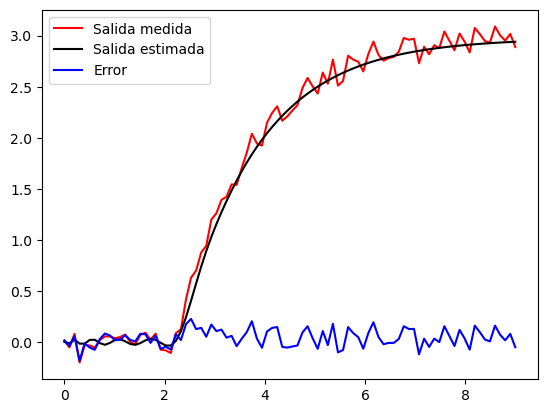

In [13]:
## Armando la función de transferencia aproximada:
ge = control.tf([Kf],[tao,1])
### Aproximación de Pade
orden = 10
num, den = control.pade(delay, orden)
gd = control.tf(num,den)
##########
ge = ge*gd
_,ye = control.step_response(ge,t)
e = yn - ye
plt.plot(t,yn,color = 'red')
plt.plot(t,ye,color = 'black')
plt.plot(t,e,color = 'blue')
plt.legend(['Salida medida','Salida estimada','Error'])
ge